<h1>Testing for Heteroscedasticity</h1>

In this notebook we will run the <b>White test</b> for heteroscedasticity.

In [35]:
# Import the required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [36]:
# Load the data set and plot de dependent variable

df = pd.read_csv('monthly_gold_price_index_fred.csv',header=0, 
                 infer_datetime_format=True, parse_dates=[0], index_col=[0])
df.head()

,Export_Price_Index_of_Gold
DATE,
2001-01-01,97.0
2001-02-01,94.8
2001-03-01,93.7
2001-04-01,93.9
2001-05-01,93.1


In [37]:
df.shape

(132, 1)

In [38]:
# Adding a new column (Time_Period) with intengers from 1 to 132

df['Time_Period'] = range(1, len(df)+1)
print(df.head(10))

            Export_Price_Index_of_Gold  Time_Period
DATE                                               
2001-01-01                        97.0            1
2001-02-01                        94.8            2
2001-03-01                        93.7            3
2001-04-01                        93.9            4
2001-05-01                        93.1            5
2001-06-01                        97.2            6
2001-07-01                        94.7            7
2001-08-01                        94.4            8
2001-09-01                        95.9            9
2001-10-01                        99.8           10


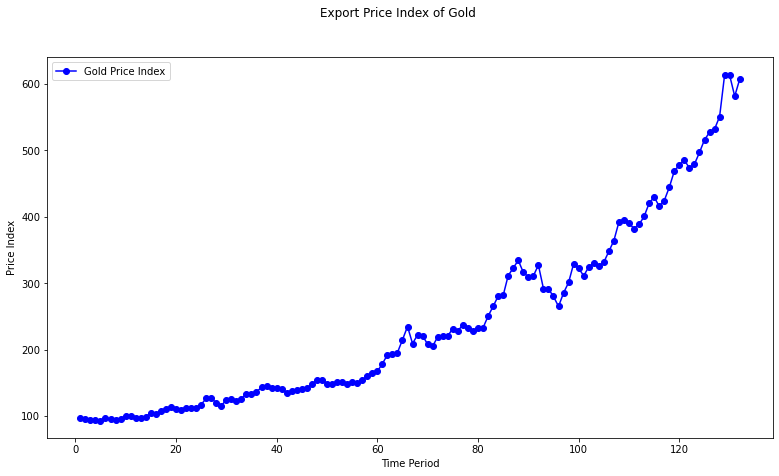

In [39]:
# Create a new mpyplot figure to plot into
fig = plt.figure(figsize = (13, 7))

# Setting the title of the plot
fig.suptitle('Export Price Index of Gold')

# Setting the X and Y axis labels
plt.xlabel('Time Period')
plt.ylabel('Price Index')

# Plot the time series and store the plot in the actual variable. (We'll need that later for the legend)
actual, = plt.plot(df['Time_Period'],
                  df['Export_Price_Index_of_Gold'], 'bo-', label='Gold Price Index')

# Set up the legend
plt.legend(handles=[actual])

# Show everything
plt.show()

The price data appears to be both heteroscedastic and nonlinear

<h3>Take the log-transform and the dependent variable</h3>

Taking the log transform of the dependent variable will not only linearize the dependent variable y but will also damp down the heteroscedastic variance in y.

In [40]:
# Adding a new column (LOG_Export_Price_Index_of_Gold) with log-transformed data

df['LOG_Export_Price_Index_of_Gold'] = np.log(df['Export_Price_Index_of_Gold'])

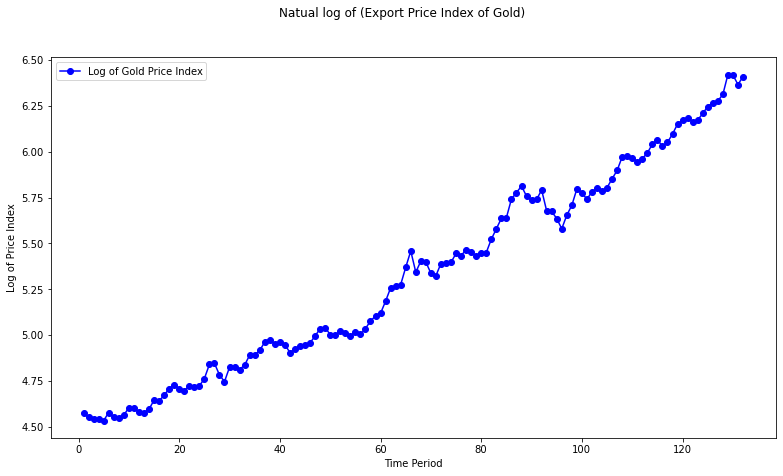

In [43]:
# Plotting the log-transformed data
fig = plt.figure(figsize = (13, 7))

fig.suptitle('Natual log of (Export Price Index of Gold)')

plt.xlabel('Time Period')
plt.ylabel('Log of Price Index')

actual, = plt.plot(df['Time_Period'],
                  df['LOG_Export_Price_Index_of_Gold'], 'bo-', label='Log of Gold Price Index')

plt.legend(handles=[actual])

# Show everything
plt.show()

The log transform has reduced the nonlinearity in the time series.

<h1>Fit an Ordinary Linear Square (OLS) linear regression model to the log-transformed data set</h1> 

The regression expression for out primary model is:<br>
<i>LOG_Export_Price_Index_of_Gold = β_0 + β_1 * Time_Period + ϵ

In [45]:
# Import the packages

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

In [50]:
# From the model expression in patsy we are telling that LOG_Export_Price_Index_of_Gold depends on Time_Period.
expr = 'LOG_Export_Price_Index_of_Gold ~ Time_Period'

# Build and train the OLSR model
olsr_results = smf.ols(expr, df).fit()

<h3>Plotting the residual errors (stored in the olsr_results.resid) agains the Time_Period:

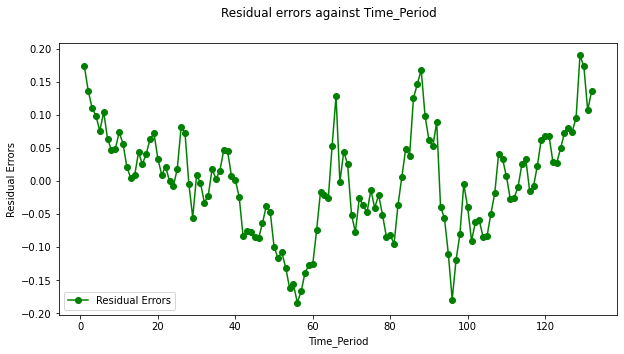

In [54]:
# Create a new pyplot figure to plot into
fig = plt.figure(figsize = (10, 5))

# Set the title of the plot
fig.suptitle('Residual errors against Time_Period')

# Set the X and Y axis labels
plt.xlabel('Time_Period')
plt.ylabel('Residual Errors')

# Plot the time series and store the plot in the actual variable
actual, = plt.plot(df['Time_Period'], olsr_results.resid, 'go-', label='Residual Errors')

# Set up the legend
plt.legend(handles=[actual])

# Show everything
plt.show()

<h1>Running the White Test of the heteroscedasticity on the residual errors</h1>

The White test uses an auxiliary OLSR model in which the dependent variable is the square of the residuals from the primary model and the explanatory variables are the primary model’s explanatory variables, their squares and their cross products.

In [55]:
# Adding a column for square of the residuals from the primary model
df['SQ_RESID'] = np.power(olsr_results.resid, 2.0)

# Adding another column for the square of Time_Period
df['SQ_Time_Period'] = np.power(df['Time_Period'], 2.0)

In [57]:
# Constructing the model expression for our auxiliary model
aux_expr = 'SQ_RESID ~ Time_Period + SQ_Time_Period'

# Building X and y matrices
y, X = dmatrices(aux_expr, df, return_type='dataframe')

# Adding a column to X for saving the regression intercept:
X = sm.add_constant(X)

# Building and training an OLSR model
aux_olsr_results = sm.OLS(y, X).fit()

In [59]:
# Printing the results
print(aux_olsr_results.summary())

                            OLS Regression Results                            
Dep. Variable:               SQ_RESID   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.5240
Date:                Wed, 25 Nov 2020   Prob (F-statistic):              0.593
Time:                        15:04:37   Log-Likelihood:                 448.64
No. Observations:                 132   AIC:                            -891.3
Df Residuals:                     129   BIC:                            -882.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0058      0.002      2.

<h3>Analyzing the results of the auxiliary model</h3>

<b>R²: </b> the model explained only 8% of the variance in the squared residuals. Indicates a rather poor fit.<br>
<b>F-Statistic: </b> The P-value > 5% makes us accept the H0 (that the model's parameter values are not jointly significant). This model is no better than a mean model.<br>
<b>Significante of regression coefficients: </b> The p-value of <i>Time_Period</i> (0.812) and <i>SQ_Time_Period</i> (0.634) are quite high, so we accept the H0 (moth coefficients are not significant) - they are basically zero.

The log-transform dampened down the heteroscedasticity in the raw gold price index to a level that the White test cannot detect.

<h1>Running the White test using statsmodels</h1>

In [61]:
# Importing the test package
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

The het_white(resid, exog) test in statsmodels takes two parameters:

resid: An array of residuals from your primary regression model. In our case, resid is olsr_results.resid<br>
exog: A matrix (e.g. a numpy array) of explanatory variables X from the primary model. In our case exog is Time_Period + Intercept

In [62]:
# Pulling out the X matrix containing the Time_Period and the intercept comlumns from datas Data Frame
expr = 'LOG_Export_Price_Index_of_Gold ~ Time_Period'
y, X = dmatrices(expr, df, return_type='dataframe')

In [63]:
# Executing the White test
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(olsr_results.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 1.0637754647238826),
 ("LM test's p-value:", 0.5874948891258364),
 ('F-statistic:', 0.5240224217417021),
 ("F-test's p-value:", 0.5933889438779911)]

<b>LM test:</b> The LM test’s statistic follows the Chi-squared distribution with degrees of freedom = DF of model minus one = (3–1) = 2. It’s p-value (0.587) is very high. So we accept the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.


<b>F-test:</b> The F-test’s statistic follows the F-distribution. Again, the high p-value of 0.593 confirms the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.


Overall, we conclude that the residual errors are homoscedastic.
This agrees with our earlier analysis that the residuals are homoscedastic.

This notebook was based on a post from Towards Data Science written by Sachin Date (https://towardsdatascience.com/heteroscedasticity-is-nothing-to-be-afraid-of-730dd3f7ca1f)